# Introduction

In this lab, we will learn how to use the TransformedTargetRegressor from the scikit-learn library. We will apply it to two different datasets to observe the benefits of transforming the target values before training a linear regression model. We will use synthetic data and the Ames housing data set to illustrate the impact of transforming the target values.

# Import necessary libraries and load synthetic data

We start by importing necessary libraries and loading synthetic data. We generate a synthetic random regression dataset and modify the targets by translating all targets such that all entries are non-negative and applying an exponential function to obtain non-linear targets which cannot be fitted using a simple linear model. We then use a logarithmic (np.log1p) and an exponential function (np.expm1) to transform the targets before training a linear regression model and using it for prediction.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import median_absolute_error, r2_score, PredictionErrorDisplay

# Generate synthetic data
X, y = make_regression(n_samples=10_000, noise=100, random_state=42)

# Modify the targets
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

# Plot the target distributions

We plot the probability density functions of the target before and after applying the logarithmic functions.

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 2000])
ax0.set_ylabel(['Probability'])
ax0.set_xlabel('Target')
ax0.set_title('Target, distribution')

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle('Synthetic data', y=1.05)
plt.tight_layout()

In [ ]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

# 1. Статистический тест: Шапиро–Уилка

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(y_trans)
print(f"Shapiro-Wilk test: stat={stat:.3f}, p-value={p:.3f}")


In [ ]:
stat, p = shapiro(y)
print(f"Shapiro-Wilk test: stat={stat:.3f}, p-value={p:.3f}")


Интерпретация:

- H₀ (нулевая гипотеза): данные распределены нормально.

- Если p > 0.05, то нет оснований отклонять гипотезу → распределение можно считать нормальным.

- Если p < 0.05, то распределение скорее всего не нормально.

# 2. Визуальный способ: QQ-plot (квантиль-квантиль)

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(y_trans, dist="norm", plot=plt)
plt.title("QQ-plot for transformed target")
plt.show()

In [ ]:
stats.probplot(y, dist="norm", plot=plt)
plt.title("QQ-plot for transformed target")
plt.show()

Интерпретация:

- Если точки примерно лежат на прямой — распределение близко к нормальному.

- Сильные отклонения от прямой — признак ненормальности.

# Train and evaluate a linear regression model on the original targets

We train and evaluate a linear regression model on the original targets. Due to the non-linearity, the model trained will not be precise during prediction.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

score = {
    "R2": f"{r2_score(y_test, y_pred_ridge):.3f}",
    "MedAE": f"{median_absolute_error(y_test, y_pred_ridge):.3f}",
}

print("Linear Regression on original targets:")
for key, val in score.items():
    print(f"{key}: {val}")

# Train and evaluate a linear regression model on the transformed targets

We train and evaluate a linear regression model on the transformed targets using TransformedTargetRegressor. The logarithmic function linearizes the targets, allowing better prediction even with a similar linear model as reported by the median absolute error (MedAE).

In [ ]:
ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

score = {
    "R2": f"{r2_score(y_test, y_pred_ridge_with_trans_target):.3f}",
    "MedAE": f"{median_absolute_error(y_test, y_pred_ridge_with_trans_target):.3f}",
}

print("\nLinear Regression on transformed targets:")
for key, val in score.items():
    print(f"{key}: {val}")

# Plot actual vs predicted values for both models

We plot actual vs predicted values for both models and add the score in the legend of each axis.

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

# Load and preprocess Ames housing data

We load the Ames housing data set and preprocess it by keeping only numeric columns and removing columns with NaN or Inf values. The target to be predicted is the selling price of each house.

In [19]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import quantile_transform, QuantileTransformer

ames = fetch_openml(name="house_prices", as_frame=True, parser="pandas")

# Keep only numeric columns
X = ames.data.select_dtypes(np.number)

# Remove columns with NaN or Inf values
X = X.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"])

# Let the price be in k$
y = ames.target / 1000
y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

The quantile_transform function is used to transform the features of a dataset to follow a uniform or normal distribution. This transformation is particularly useful for making the data more Gaussian-like, which can improve the performance of machine learning algorithms that assume normally distributed data.

The main purposes of quantile_transform include:

Normalization: It scales the data to a specified distribution, which can help in reducing the influence of outliers.
Feature Engineering: It can create features that are more suitable for modeling, especially when the original features have skewed distributions.
Improving Model Performance: By transforming the data to a more standard distribution, it can enhance the performance of algorithms that are sensitive to the distribution of the input data.

# Plot target distributions for Ames housing data

We plot the probability density functions of the target before and after applying the QuantileTransformer.

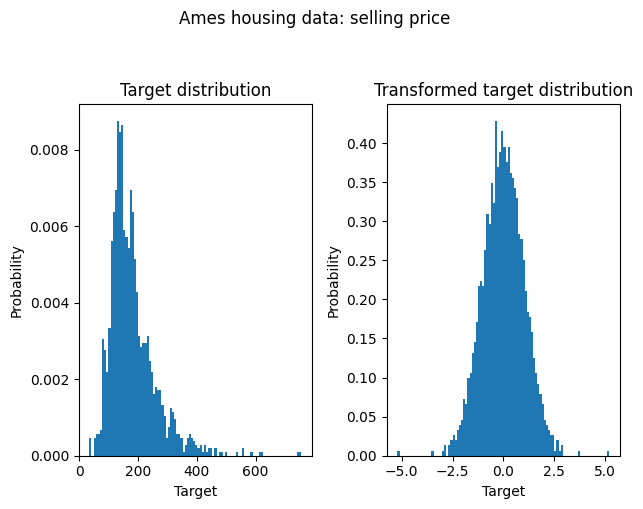

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()

# Train and evaluate a linear regression model on the original targets for Ames housing data

We train and evaluate a linear regression model on the original targets for Ames housing data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

score = {
    "R2": f"{r2_score(y_test, y_pred_ridge):.3f}",
    "MedAE": f"{median_absolute_error(y_test, y_pred_ridge):.3f}",
}

print("\nLinear Regression on original targets:")
for key, val in score.items():
    print(f"{key}: {val}")


Linear Regression on original targets:
R2: 0.821
MedAE: 16.144


# Train and evaluate a linear regression model on the transformed targets for Ames housing data

We train and evaluate a linear regression model on the transformed targets using TransformedTargetRegressor for Ames housing data.

In [25]:
from sklearn.preprocessing import QuantileTransformer

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

score = {
    "R2": f"{r2_score(y_test, y_pred_ridge_with_trans_target):.3f}",
    "MedAE": f"{median_absolute_error(y_test, y_pred_ridge_with_trans_target):.3f}",
}

print("\nLinear Regression on transformed targets:")
for key, val in score.items():
    print(f"{key}: {val}")


Linear Regression on transformed targets:
R2: 0.899
MedAE: 10.900


# Plot actual vs predicted values and residuals vs predicted values for both models

We plot actual vs predicted values and residuals vs predicted values for both models and add the score in the legend of each axis.

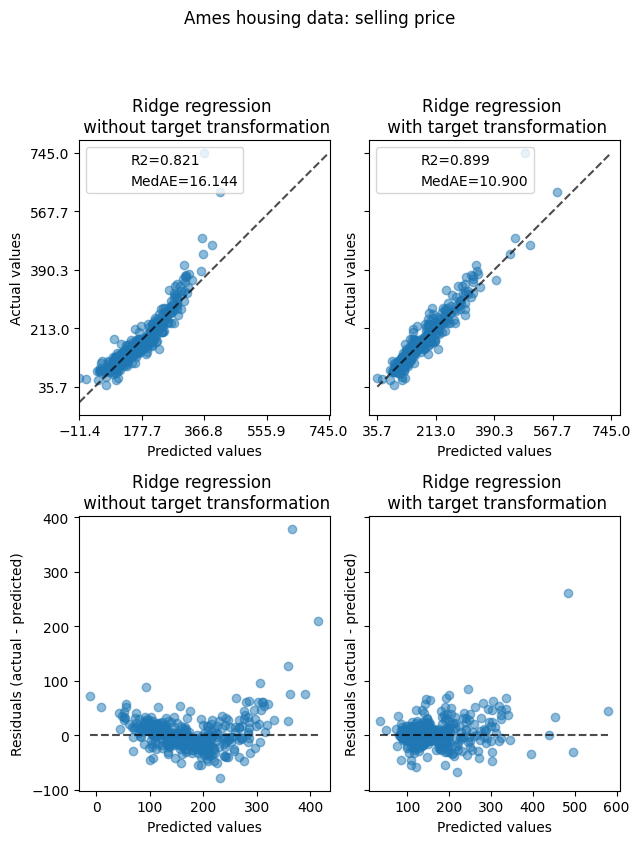

In [27]:
from sklearn.preprocessing import QuantileTransformer

f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

# plot the actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1]], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0[0].set_title("Ridge regression \n without target transformation")
ax0[1].set_title("Ridge regression \n with target transformation")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("Ridge regression \n without target transformation")
ax1[1].set_title("Ridge regression \n with target transformation")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()
plt.show()

# Summary

In this lab, we learned how to use the TransformedTargetRegressor from the scikit-learn library. We applied it to two different datasets to observe the benefits of transforming the target values before training a linear regression model. We used synthetic data and the Ames housing data set to illustrate the impact of transforming the target values. We observed that the logarithmic function linearized the targets, allowing better prediction even with a similar linear model as reported by the median absolute error (MedAE). We also observed that the effect of the transformer was weaker for the Ames housing data set, but still resulted in an increase in R2 and a large decrease of the MedAE.